# Sun - VIRGO/SoHO

Using photometric observations of the Sun by the VIRGO instrument onboard the SoHO spacecraft, with the p-mode frequencies determined by Lund et al. (2017).

In [1]:
import numpy as np
import asterion as ast
from asterion import GlitchModel, Inference
import matplotlib.pyplot as plt

/Users/alyttle/.pyenv/versions/asterion/lib/python3.9/site-packages/jax/_src/lib/__init__.py:33: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "


In [2]:
ast.style.use("asterion-light")

In [3]:
nu_max = (3090., 5.)  # in microhertz
delta_nu = (135.2, 0.5)   # in microhertz
teff = (4777., 10.)    # in Kelvin

In [4]:
from astroquery.vizier import Vizier

In [5]:
v = Vizier(row_limit=-1)
tables = v.query_constraints("J/ApJ/835/172/table6", KIC="Sun")

WARNING[2022-05-19 15:54:18,220]: UnitsWarning: Unit 'ppm' not supported by the VOUnit standard. Did you mean Pm or pm?


In [6]:
df = tables[0].to_pandas()
df.head()

,KIC,n,l,Freq,e_Freq,E_Freq,Amp,e_Amp,E_Amp,Width,e_Width,E_Width,l_lnK,lnK
0,Sun,15,1,2291.97523,0.03812,0.03682,NaN,NaN,NaN,NaN,NaN,NaN,>,6.0
1,Sun,15,2,2352.12584,0.18294,0.18089,NaN,NaN,NaN,NaN,NaN,NaN,,0.2
2,Sun,16,0,2362.81128,0.07513,0.09048,1.21202,0.10554,0.09019,0.38777,0.10294,0.12436,>,6.0
3,Sun,16,1,2425.50557,0.07310,0.06752,NaN,NaN,NaN,NaN,NaN,NaN,>,6.0
4,Sun,16,2,2485.66414,0.18478,0.20665,NaN,NaN,NaN,NaN,NaN,NaN,>,6.0


In [7]:
mask = (df["l"] == 0) & (df["lnK"] >= 6.0) # radial orders only
n = df.loc[mask, "n"].to_numpy()
nu, nu_low, nu_high = df.loc[mask, ["Freq", "e_Freq", "E_Freq"]].to_numpy().T

In [8]:
df.loc[mask]

,KIC,n,l,Freq,e_Freq,E_Freq,Amp,e_Amp,E_Amp,Width,e_Width,E_Width,l_lnK,lnK
2,Sun,16,0,2362.81128,0.07513,0.09048,1.21202,0.10554,0.09019,0.38777,0.10294,0.12436,>,6.0
5,Sun,17,0,2496.33553,0.10216,0.08959,1.78554,0.10822,0.11599,0.80952,0.18196,0.17158,>,6.0
8,Sun,18,0,2629.92668,0.08084,0.07834,1.86303,0.12803,0.09882,0.70794,0.14943,0.18957,>,6.0
11,Sun,19,0,2764.41172,0.09621,0.10208,2.53999,0.10605,0.14166,1.28432,0.24797,0.12059,>,6.0
14,Sun,20,0,2899.06884,0.05888,0.04985,2.66153,0.11009,0.13034,0.55453,0.06785,0.11869,>,6.0
17,Sun,21,0,3033.76623,0.06558,0.05892,3.28657,0.10689,0.15073,0.87266,0.13538,0.11625,>,6.0
21,Sun,22,0,3168.49882,0.06689,0.06350,3.41756,0.12620,0.11855,1.08151,0.12263,0.12726,>,6.0
25,Sun,23,0,3303.61983,0.09015,0.09641,2.78801,0.07624,0.13981,1.31198,0.11849,0.17890,>,6.0
28,Sun,24,0,3439.12371,0.16555,0.17757,2.11492,0.11964,0.10492,1.70654,0.25504,0.26166,>,6.0
31,Sun,25,0,3575.20184,0.37344,0.42596,1.90015,0.11068,0.13714,3.22602,0.55850,0.57070,>,6.0


In [9]:
nu_err = np.mean([nu_low, nu_high], axis=0)

In [10]:
model = GlitchModel(nu_max, delta_nu, teff=teff)

INFO[2022-05-19 15:54:18,255]: Unable to initialize backend 'tpu_driver': NOT_FOUND: Unable to find driver in registry given worker: 
INFO[2022-05-19 15:54:18,256]: Unable to initialize backend 'gpu': NOT_FOUND: Could not find registered platform with name: "cuda". Available platform names are: Interpreter Host
INFO[2022-05-19 15:54:18,256]: Unable to initialize backend 'tpu': INVALID_ARGUMENT: TpuPlatform is not available.


In [11]:
infer = Inference(model, n=n, nu=nu, nu_err=nu_err, seed=10)
infer.prior_predictive()  # <-- check prior is sensible
prior_data = infer.get_data()

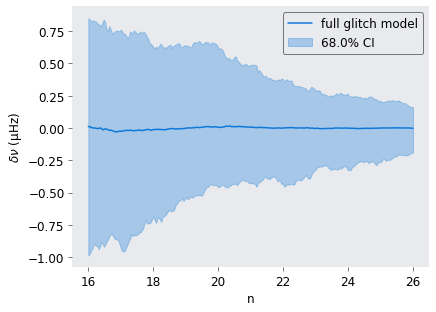

In [12]:
ast.plot_glitch(prior_data, group='prior');

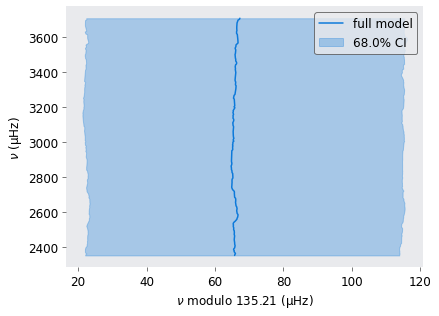

In [13]:
ast.plot_echelle(prior_data, group='prior');

In [14]:
infer.sample()
infer.posterior_predictive()

Running nested sampling using the 'multi_ellipsoid' sampler with 50 live points and 50000 maximum samples...
Completed in 13.7 seconds.


In [15]:
data = infer.get_data()

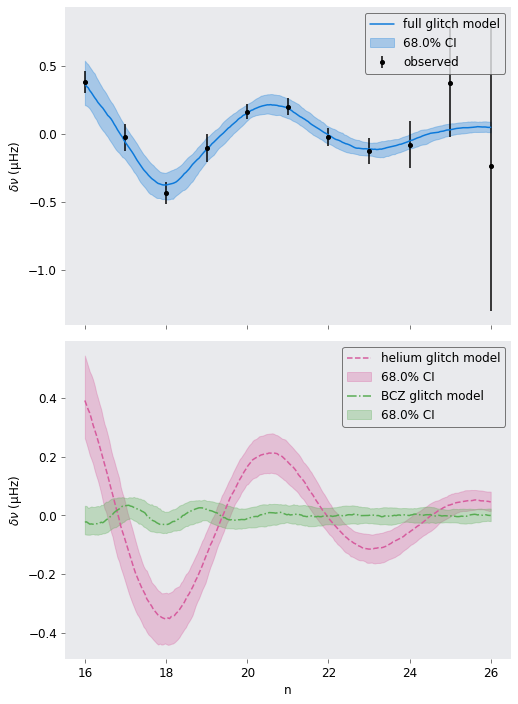

In [16]:
quantiles = [.16, .84]  # <-- 68% confidence interval

_, axes = plt.subplots(2, figsize=(8.0, 12.0), sharex=True, gridspec_kw={"hspace": 0.05})

# FULL GLITCH
ax = axes[0]
ax = ast.plot_glitch(data, quantiles=quantiles, ax=ax)
ax.set_xlabel("")  # Remove xlabel

# GLITCH COMPONANTS
ax = axes[1]
ax = ast.plot_glitch(data, kind='He', quantiles=quantiles, observed=False, ax=ax, color="C1", linestyle="--")
ax = ast.plot_glitch(data, kind='CZ', quantiles=quantiles, observed=False, ax=ax, color="C2", linestyle="-.")

Similarly, we can plot the model on an echelle plot, which folds the mode frequencies on the large frequency separation. By default, it uses the median $\Delta\nu$ from the model, but you can pass `delta_nu` as a keyword argument. Here, the echelle plot does not look right because the model's $\Delta\nu$ is sensitive to the GP. This does not matter because the plot is just a visualisation of the model and its performance.

Text(0, 0.5, '')

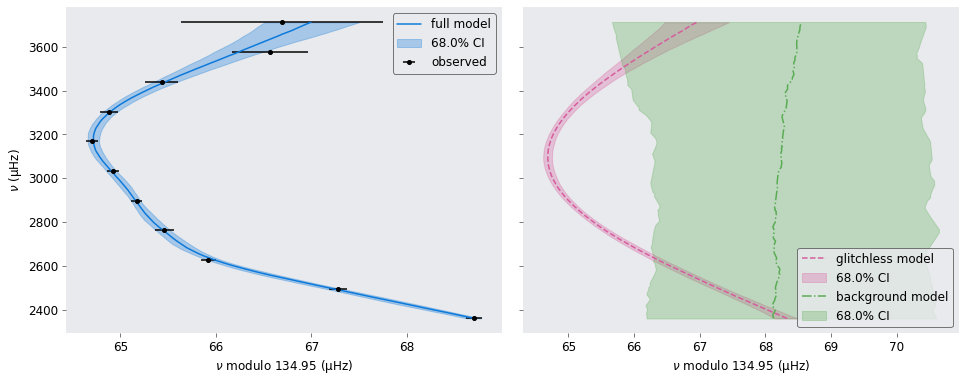

In [17]:
_, axes = plt.subplots(ncols=2, figsize=(16.0, 6.0), sharey=True, gridspec_kw={"wspace": 0.05})

# FULL GLITCH
ax = axes[0]
ax = ast.plot_echelle(data, quantiles=quantiles, ax=ax)

# GLITCH COMPONANTS
ax = axes[1]
ax = ast.plot_echelle(data, kind='glitchless', quantiles=quantiles, observed=False, ax=ax, color="C1", linestyle="--")
ax = ast.plot_echelle(data, kind='background', quantiles=quantiles, observed=False, ax=ax, color="C2", linestyle="-.")
ax.set_ylabel("")  # Remove ylabel

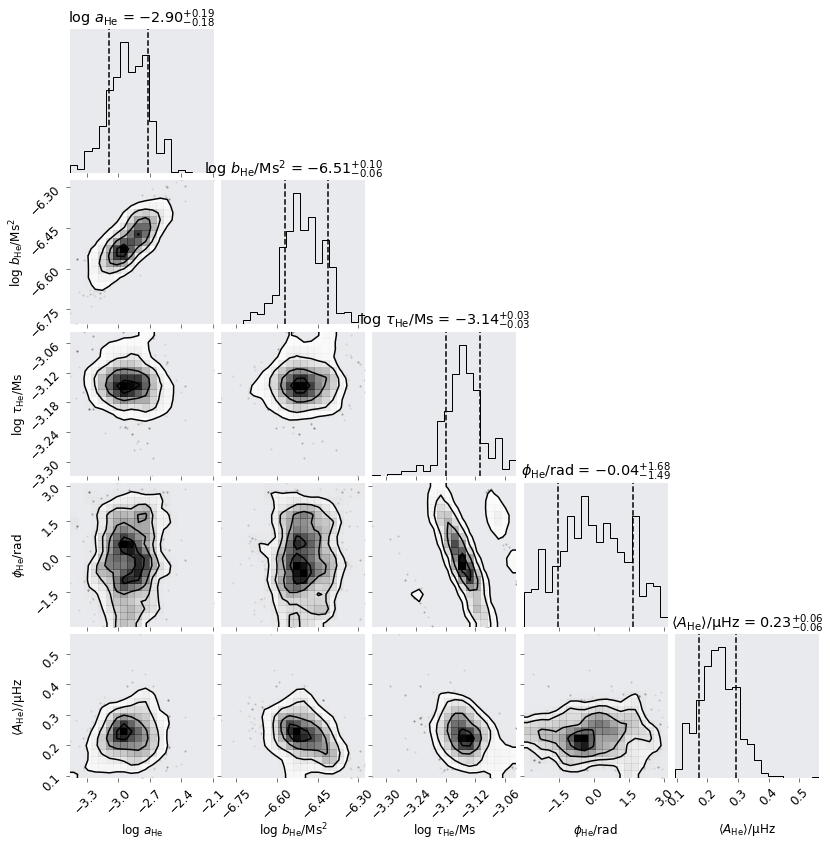

In [18]:
ast.plot_corner(data, var_names=['log_a_he', 'log_b_he', 'log_tau_he', 'phi_he', 'he_amplitude']);

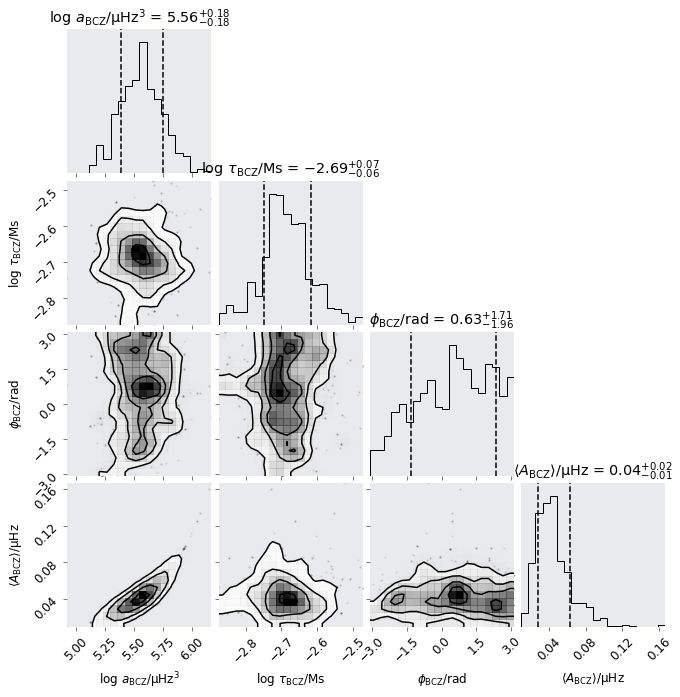

In [19]:
ast.plot_corner(data, var_names=['log_a_cz', 'log_tau_cz', 'phi_cz', 'cz_amplitude']);

Be careful when interpretting $\Delta\nu$ and $\epsilon$. These parameters are specific to this model and may be sensitive to the radial orders observed.

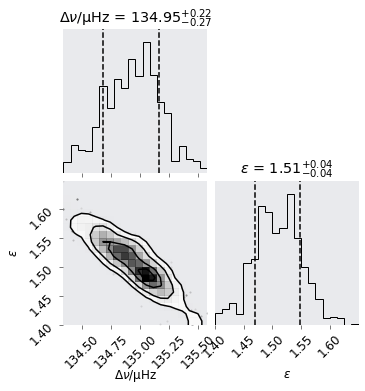

In [20]:
ast.plot_corner(data, var_names=['delta_nu', 'epsilon']);

In [21]:
import astropy.units as u

In [22]:
# Convert to physical quantity from Houdek and Gough (2007)
data.posterior["delta_he"] = np.sqrt(data.posterior["b_he"]/2)/2/np.pi
data.posterior["delta_he"].attrs["unit"] = str(u.megasecond)

In [23]:
from astropy.table import QTable

table = ast.get_table(data, dims=(), 
                      var_names=["a_he", "log_b_he", "b_he", "tau_he", "a_cz", "tau_cz", "delta_he"], 
                      fmt="astropy",
                      round_to="none")
table = QTable(table)  # <-- convert to quantity table
table

metric,a_he,log_b_he,b_he,tau_he,a_cz,tau_cz,delta_he
,,dex(Ms2),Ms2,Ms,uHz3,Ms,Ms
str4,float64,float64,float64,float64,float64,float64,float64
mean,0.001380718324176518,-6.500869499206348,3.208008443520709e-07,0.0007226567695351438,395223.69067449856,0.0020842399713185845,6.348174851557523e-05
sd,0.0006480942685666692,0.07870703305128718,5.842172633448886e-08,6.681010034684075e-05,175112.4815124622,0.0003406628687031673,5.752465050834587e-06
16th,0.0008209341410042362,-6.5720237428669295,2.6790231448792426e-07,0.0006631413696328408,242093.8618476872,0.0017861562354831082,5.824964923809738e-05
50th,0.0012486349030737716,-6.507514824802665,3.108029807182414e-07,0.0007184067435143794,364497.2640345901,0.0020316379057183026,6.274046330512999e-05
84th,0.0019170379777640036,-6.412282070038438,3.8700620651316535e-07,0.0007754622869613926,556064.3210091621,0.002409856102462946,7.001064822657776e-05


Be careful with the mean of logarithmic parameters, quantiles are much better here.

In [24]:
mean = table[table["metric"] == "mean"][0]
sd = table[table["metric"] == "sd"][0]

p16 = table[table["metric"] == "16th"][0]
p50 = table[table["metric"] == "50th"][0]
p84 = table[table["metric"] == "84th"][0]

Approx acoustic depth of the helium-II ionization zone

In [25]:
dp = 1
col = "tau_he"
unit = u.s  # <-- convert to seconds

med = p50[col].to(unit)
em = med - p16[col].to(unit)
ep = p84[col].to(unit) - med
print(f"{col} = {med:.{dp}f} (- {em:.{dp}f}) (+ {ep:.{dp}f})")

tau_he = 718.4 s (- 55.3 s) (+ 57.1 s)


Approx acoustic width of the helium-II ionization zone

In [26]:
dp = 2
col = "delta_he"
unit = u.s
med = p50[col].to(unit)
em = med - p16[col].to(unit)
ep = p84[col].to(unit) - med
print(f"{col} = {med:.{dp}f} (- {em:.{dp}f}) (+ {ep:.{dp}f})")

delta_he = 62.74 s (- 4.49 s) (+ 7.27 s)


Acoustic depth of the base of the convective zone

In [27]:
dp = 1
col = "tau_cz"
unit = u.s
med = p50[col].to(unit)
em = med - p16[col].to(unit)
ep = p84[col].to(unit) - med
print(f"{col} = {med:.{dp}f} (- {em:.{dp}f}) (+ {ep:.{dp}f})" )

tau_cz = 2031.6 s (- 245.5 s) (+ 378.2 s)
